In [12]:
import os, sys, json
from pathlib import Path, PosixPath
import imageio
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.spatial.transform import Rotation
from utils import Sphere, initialize_rays, rendering, apply_camera_transformation, euler_to_rotation_matrix, create_homogeneous_matrix

In [3]:
"""
General folder structure (following nerfstudio convention)
/Folder
    / transforms.json
    / images/
    / images_2/
    / ...
    / images_2^(n-1)/
""";

In [4]:
def get_rays(DIR : PosixPath, image_downscale_factor = 2, max_num_images=None, random_sample=False):
    ### Find json file and image folders
    json_path = Path.joinpath(DIR, "transforms.json")
    images_path = Path.joinpath(DIR, f"images_{image_downscale_factor}")
    
    assert os.path.isfile(json_path), f"transforms.json does not exists in directory {DIR}"
    assert os.path.isdir(images_path), f"There are no images_{image_downscale_factor} folders in directory {DIR}"
    
    ### Read json file and images
    with open(json_path, "r") as jfile:
        json_file_contents =  json.load(jfile)
    
    image_paths = [os.path.join(images_path, i) for i in os.listdir(images_path)]
    assert len(json_file_contents["frames"]) == len(image_paths), "Number of camera poses must match the number of images"
    
    framenames_transforms = [(json_file_contents["frames"][i]["file_path"],json_file_contents["frames"][i]["transform_matrix"]) for i in range(len(json_file_contents["frames"]))]
    
    get_image = lambda fname:  image_paths[image_paths.index(os.path.join(DIR.as_posix(),f"images_{image_downscale_factor}",fname.split("/")[-1]))]
    fname_poseimagepath = [(pose,get_image(fname)) for fname,pose in framenames_transforms]
    
    if random_sample:
        assert max_num_images is not None, "In random subsampling, max_num_images must be an int."
        fname_poseimagepath = random.sample(fname_poseimagepath, max_num_images)
    
    frames,poses = [],[]
    for pose,imagepath in fname_poseimagepath:
        frame = imageio.imread(imagepath) / 255. # To map to [0,1]
        pose  = np.array(pose)
        pose  = np.linalg.inv(pose)
        frames.append(frame)
        poses.append(pose)       
        
    frames,poses = np.array(frames),np.array(poses)
    
    # RGBA -> RGB
    if frames.shape[3] == 4: 
        frames = frames[...:3] * frames[...:-1:] + (1 - frames[...:-1:])
    
    N = len(frames)

    H,W = frames[0].shape[0], frames[0].shape[1]
    rays_o_t, rays_d_t = torch.zeros((N,W*H,3)), torch.zeros((N,W*H,3))
    ground_truths = torch.Tensor(frames.reshape(N,H*W,3))
    for i in range(N): # TODO: Apply intrinsic transformations when scaled images are used! 
        c2w = torch.Tensor(poses[i])
        fx,fy = json_file_contents["fl_x"], json_file_contents["fl_y"]         
        rays_o, rays_d = initialize_rays(H,W,fx,fy, device="cpu")  
        rays_o, rays_d = apply_camera_transformation(rays_o, rays_d, c2w)
        rays_o_t[i] = rays_o
        rays_d_t[i] = rays_d
        
    return rays_o_t, rays_d_t,ground_truths,(H,W)

In [6]:
# rays_o, rays_d, gts, (H,W) = get_rays(PosixPath("../scooter"), image_downscale_factor=4, random_sample=True, max_num_images=30)
# plt.imshow(gts[1].reshape(H,W,-1))

In [7]:
# TODO: 
#   - Apply mean centering given the poses, or focus centering
#   - Apply rotation given the poses (mean rotating)

class Voxels(nn.Module):
    
    def __init__(self, nb_voxels=100, scale=1, device="cpu") -> None:
        super(Voxels, self).__init__()
        
        self.nb_voxels = nb_voxels
        self.voxels    = torch.nn.Parameter(torch.rand((self.nb_voxels,self.nb_voxels,self.nb_voxels,4), device=device),requires_grad=True) # XYZ,RGBA
        self.scale = scale
        self.device = device
        
    def forward(self, X):
        """
        X: nb_rays*nb_bins,3
        """
        x = X[:,0]
        y = X[:,1]
        z = X[:,2]
        
        # Are given points inside voxel grid?
        cond = (x.abs() < (self.scale/2.)) & (y.abs() <(self.scale/2.)) & (z.abs() <(self.scale/2.)) 
        # Digitize (Coordinate -> Index)
        indx = (x[cond] / (self.scale/self.nb_voxels) + self.nb_voxels/2).floor().type(torch.long) - 1
        indy = (y[cond] / (self.scale/self.nb_voxels) + self.nb_voxels/2).floor().type(torch.long) - 1
        indz = (z[cond] / (self.scale/self.nb_voxels) + self.nb_voxels/2).floor().type(torch.long) - 1
        
        colors_densities = torch.zeros((X.shape[0],4),dtype=torch.float32, device=self.device)
        colors_densities[cond, :3] = self.voxels[indx,indy,indz,:3]
        colors_densities[cond, -1] = self.voxels[indx,indy,indz,-1] * 10
        
        return torch.sigmoid(colors_densities[:,:3]), torch.relu(colors_densities[:,-1:])
        
    def intersect(self,X):
        return self.forward(X)

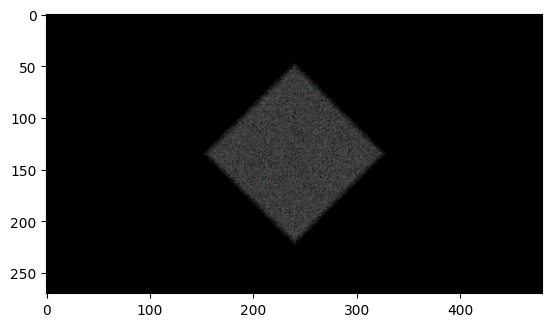

In [8]:
model = Voxels(scale=0.1)
ro,rd = initialize_rays(270,480, 1200,1200)
H = euler_to_rotation_matrix([45,0,0])
H = create_homogeneous_matrix(H)
H[2,3] = 1
ro,rd = apply_camera_transformation(ro,rd,torch.Tensor(H))
img = rendering([model],ro,rd)

plt.imshow(img.reshape(270,480,-1).detach().numpy())

In [9]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/experiment_1',flush_secs=3)

def training(model, data_loader, optim, loss_fn, scheduler, tn, tf, nb_bins, nb_epochs, N, device="cpu"):
    os.makedirs("./outputs", exist_ok=True)
    training_loss = []
    for epoch in range(nb_epochs):
        step = 0
        for batch in tqdm(data_loader):
            r_o = batch[:,:3].to(device)
            r_d = batch[:,3:6].to(device)
                        
            pred = rendering([model],r_o,r_d,tn,tf,nb_bins,device)
            gt  = batch[:,6:].to(device)
            loss = loss_fn(pred,gt)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            training_loss.append(loss.item())
            
            # Log the loss value to TensorBoard
            writer.add_scalar('Loss/train', loss.item(), step)
            step+=1
            
            if step%500==0:
                with torch.no_grad():
                    idx = random.randint(0,N-1)
                    img_pred = rendering([model],rays_o[idx],rays_d[idx],tn,tf, nb_bins,device=device).reshape(H,W,-1).detach().numpy()
                    img_gt = gts[idx].reshape(H,W,-1).detach().numpy()
                    
                    imsave = np.concatenate((img_gt,img_pred),axis=1)
                    plt.imsave(f"./outputs/save_{epoch}_{step}.png", imsave)
            
        scheduler.step()
    
    writer.close()
    return training_loss

In [10]:
import math
def minimize_difference_forsubplots(N):
    min_diff = float('inf')
    best_pair = (1, N)
    
    for i in range(1, int(math.sqrt(N)) + 1):
        if N % i == 0:
            x = i
            y = N // i
            diff = abs(x - y)
            
            if diff < min_diff:
                min_diff = diff
                best_pair = (x, y)
    
    return best_pair

In [54]:
N = 5
rays_o, rays_d, gts,(H,W) = get_rays(PosixPath("../scooter"), max_num_images=N,random_sample=True)

batch_size = 1024
dataloader = DataLoader(
    torch.cat((rays_o.reshape(-1,3), rays_d.reshape(-1,3), gts.reshape(-1,3)), dim=-1),
    batch_size=batch_size,
    shuffle=True
)

model = Voxels(nb_voxels=300,scale=10)
tn = 0.1
tf = 20
nb_bins=200
device="cuda:0"
nb_epochs=15
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5,10], gamma=.5)
data_loader = dataloader
loss = torch.nn.L1Loss()

/tmp/ipykernel_1307916/1712766736.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(imagepath) / 255. # To map to [0,1]


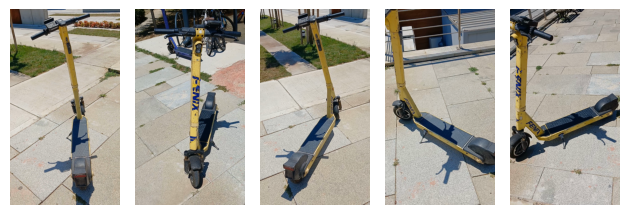

In [55]:
nrows,ncols = minimize_difference_forsubplots(N)
fig,axes = plt.subplots(nrows,ncols)
axes = axes.flatten()

# Plot each image
for i in range(N):
    axes[i].imshow(gts[i].reshape(H,W,3))
    axes[i].axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

In [56]:
training(model, data_loader, optim, loss, scheduler, tn, tf, nb_bins, nb_epochs, N, device="cpu")

 59%|█████▉    | 1496/2532 [08:43<06:02,  2.86it/s]


KeyboardInterrupt: 

In [58]:
save_dict = {
    "model" : model,
    "tn" : 0.1,
    "tf" : 20,
    "nb_bins":200
}

In [66]:
with open("./saved_model_2024_08_16_2.pkl", "wb") as f:
    pickle.dump(save_dict, f)

In [14]:
with open("./saved_model_2024_08_16.pkl", "rb") as f:
    A = pickle.load(f)

model = A["model"]

In [29]:
ro,rd = initialize_rays(540,960, 1909,1894)
H = euler_to_rotation_matrix([45,0,0])
H = create_homogeneous_matrix(H)
H[2,3] = 5
ro,rd = apply_camera_transformation(ro,rd,torch.Tensor(H))
img = rendering([model],ro,rd,A["tn"],A["tf"],A["nb_bins"])

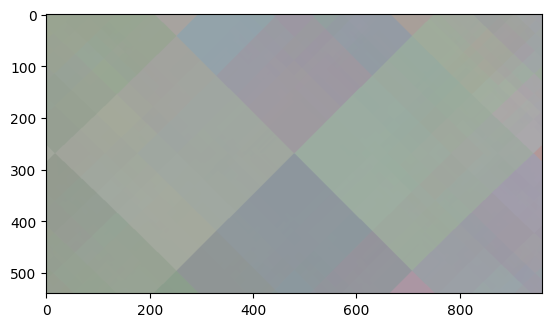

In [30]:
plt.imshow(img.reshape(540,960,-1).detach().numpy())

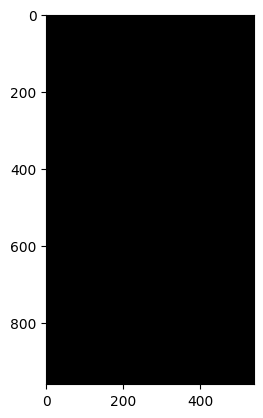

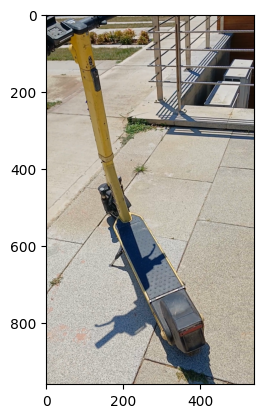

In [53]:
idx = 0
img = rendering([model],rays_o[idx],rays_d[idx],tn,tf)

plt.figure()
plt.imshow(img.reshape(H,W,-1).detach().numpy())
plt.figure()
plt.imshow(gts[idx].reshape(H,W,-1).detach().numpy())